In [10]:
import numpy as np
import matplotlib.pyplot as plt

NX = 100
NY = 100
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])# weights, note that the last four (edges) 
# are the interpolation points with the highest velocity; weights influence probability density
c_ij = np.array([[0, 1,  0, -1, 0, 1, -1, -1, 1], [0, 0, 1, 0, -1, 1, 1, -1, -1]])# velocities x and y component

In [11]:
u_anm = np.zeros((2,NX,NY))

In [12]:
y = np.arange(0, NY)
L = NY
v = np.sin(2*np.pi/L*y)
# wave along the y-direction at one x

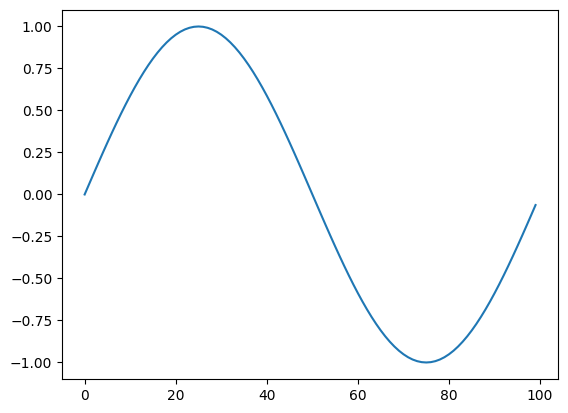

In [13]:
plt.plot(v)
plt.show()

In [16]:
# set initial density
rho = np.zeros((NX, NY))
rho[:,:] = 1 + 0.5 * np.sin(2*np.pi*y/L)
u = np.zeros((2,NX, NY))

print(rho)

[[1.         1.03139526 1.06266662 ... 0.90630934 0.93733338 0.96860474]
 [1.         1.03139526 1.06266662 ... 0.90630934 0.93733338 0.96860474]
 [1.         1.03139526 1.06266662 ... 0.90630934 0.93733338 0.96860474]
 ...
 [1.         1.03139526 1.06266662 ... 0.90630934 0.93733338 0.96860474]
 [1.         1.03139526 1.06266662 ... 0.90630934 0.93733338 0.96860474]
 [1.         1.03139526 1.06266662 ... 0.90630934 0.93733338 0.96860474]]


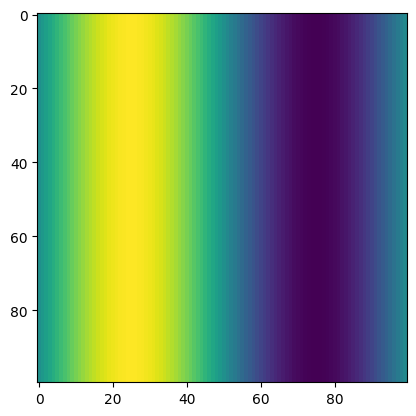

In [17]:
fig, ax = plt.subplots()
ax.imshow(rho)
plt.show()

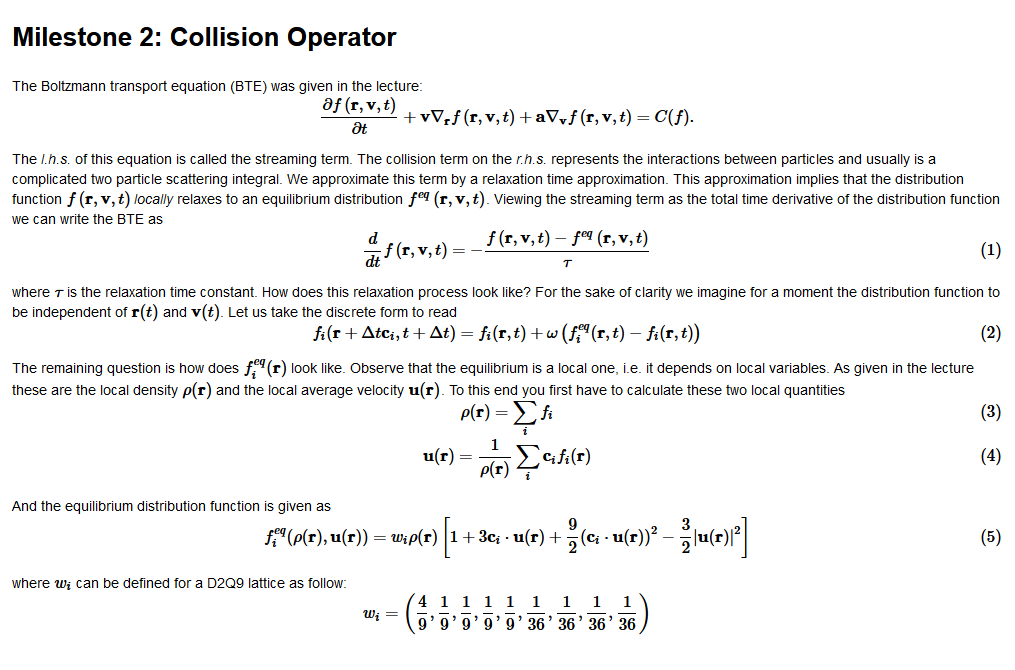

In [97]:
def dens_lattice_point(f_vxy):
    # Milestone 1: ...
    return np.einsum('vxy -> xy', f_vxy)

def vel_field_lattice_point(f_inm):
    # Milestone 1: ...
    # Compute the average velocity of every point on the grid
    return 1/dens_lattice_point(f_inm) * np.einsum('ij, ixy -> jxy', c_ij.T, f_inm)

def stream(f_ijk):
    # Milestone 1: ...
    # define a velocity vector containing all shifting directions
    c_ij = [[0, 0],[0, 1],[-1, 0],[0, -1], [1, 0], [-1, 1], [-1, -1], [1, -1], [1, 1]]
    for p in range(1,9):
        f_ijk[p] = np.roll(f_ijk[p], shift=c_ij[p], axis=(0,1))
    return f_ijk

def equi_dist(rho, av_vel):
    # Milestone 1: (5)
    # compute f_eq 
    f_eq_vxy = np.zeros((9, NX, NY))
    
    u_abs = np.einsum('inm, inm -> nm', av_vel, av_vel)
    for j in range(9):
        scal = np.einsum('j, jnm -> nm', c_ij.T[j], av_vel)
        f_eq_vxy[j] = w_i[j] * rho *(1 + 3*scal + 9/2*scal**2- 3/2 * u_abs)
    return f_eq_vxy

def comp_new_dist(f_inm, f_eq_inm, omega = 1):
    # Milestone 2: (2)
    return f_inm +  omega * (f_eq_inm - f_inm)

In [52]:
# simulate the streaming
f_inm = np.einsum('i,jk -> ijk', w_i, np.ones((NX, NY)))# product of two arrays

f_eq_vxy = np.zeros((9, NX, NY)) # reshape?

In [53]:
f_eq = equi_dist(rho, u)

In [54]:
for t in range(1000):
    f_eq = equi_dist(rho, u)
    f_inm = stream(f_inm)
    f_inm = comp_new_dist(f_inm, f_eq, omega = 1)
    rho = dens_lattice_point(f_inm)
    u = vel_field_lattice_point(f_inm)
#give the initial rho and u from 2 ot the initial equilibrium
# set equi in the start, then just do streaming without changing the equi again
# one would expect the wave to decay, as the streaming operation moves the density from each point into the different directions

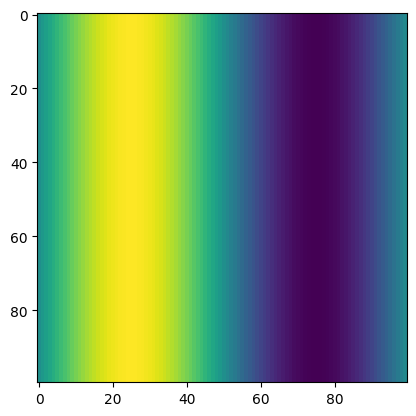

In [55]:
fig, ax = plt.subplots()
ax.imshow(rho)
plt.show()

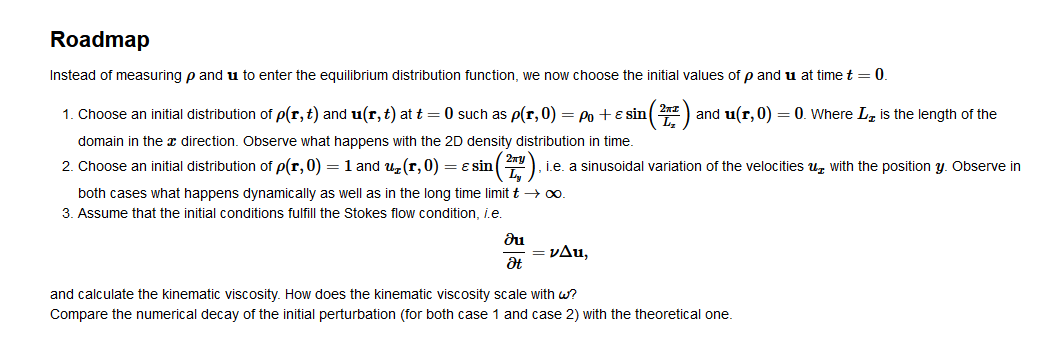

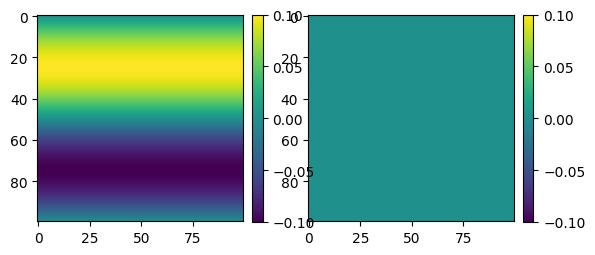

In [105]:
f_inm = np.einsum('i,jk -> ijk', w_i, np.ones((NX, NY)))# product of two arrays


# How to implement the initialization of u? 
# Is it enough to use u in the first equi-dist?
X, Y = np.meshgrid(np.arange(NX),np.arange(NY))
ux = 0.1*np.sin(2*np.pi/L*Y)
uy = np.zeros((NX, NY))
u = np.stack((ux, uy), axis=0)
# plt.imshow(u[0])
# plt.show()

rho[:,:] = 1
f_inm_eq = equi_dist(rho, u)
fig, axes = plt.subplots(1,2)
for idx in range(2):
    im = axes[idx].imshow(u[idx])
    plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.00627492  0.00627492  0.00627492 ...  0.00627492  0.00627492
   0.00627492]
 [ 0.01252508  0.01252508  0.01252508 ...  0.01252508  0.01252508
   0.01252508]
 ...
 [-0.01872581 -0.01872581 -0.01872581 ... -0.01872581 -0.01872581
  -0.01872581]
 [-0.01252508 -0.01252508 -0.01252508 ... -0.01252508 -0.01252508
  -0.01252508]
 [-0.00627492 -0.00627492 -0.00627492 ... -0.00627492 -0.00627492
  -0.00627492]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.00627079  0.00627079  0.00627079 ...  0.00627079  0.00627079
   0.00627079]
 [ 0.01251684  0.01251684  0.01251684 ...  0.01251684  0.01251684
   0.01251684]
 ...
 [-0.01871349 -0.01871349 -0.01871349 ... -0.01871349 -0.01871349
  -0.01871349]
 [-0.01251684 -0.01251684 -0.01251684 ... -0.01251684 -0.01251684
  -0.01251684]
 [-0.00627079 -0.00627079 -0.00627079 ... -0.00627079 -0.00627079
  -0.00627079]]
[[ 0.          0.          0.   

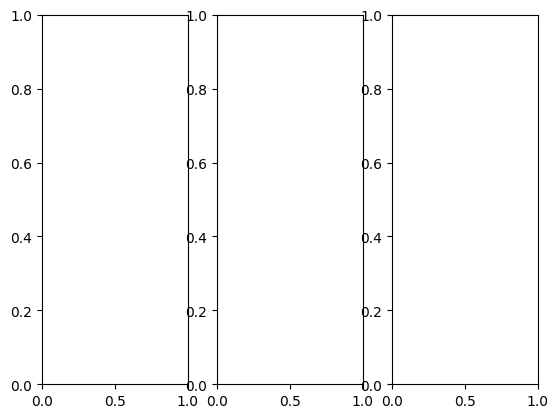

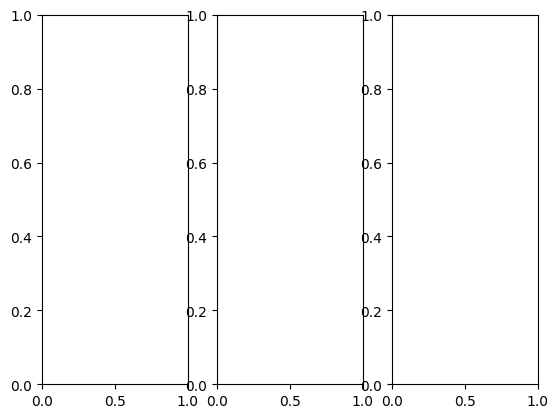

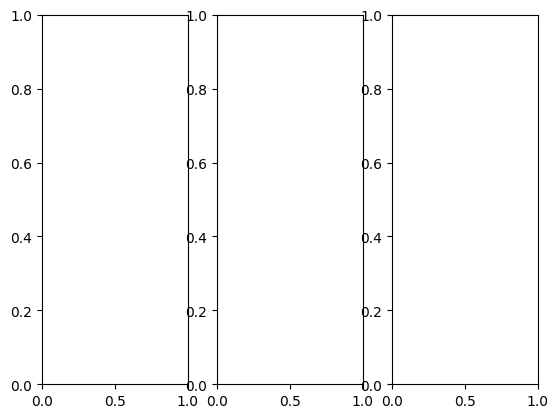

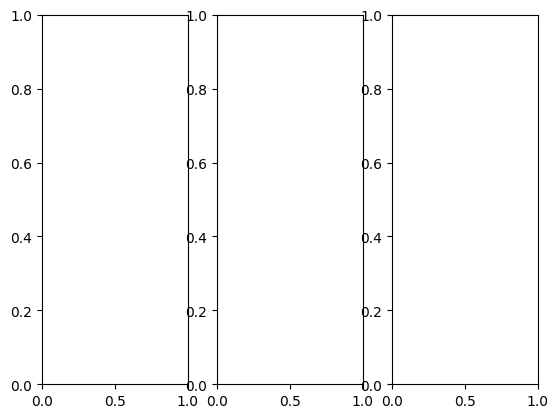

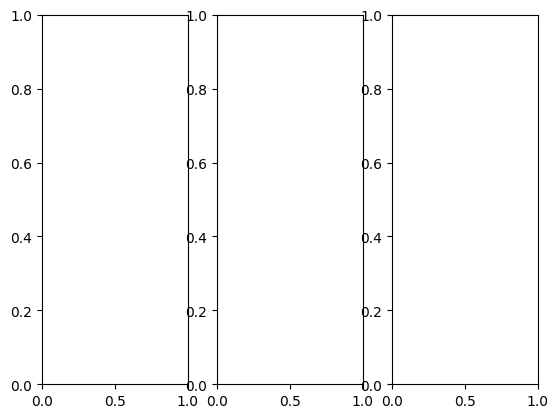

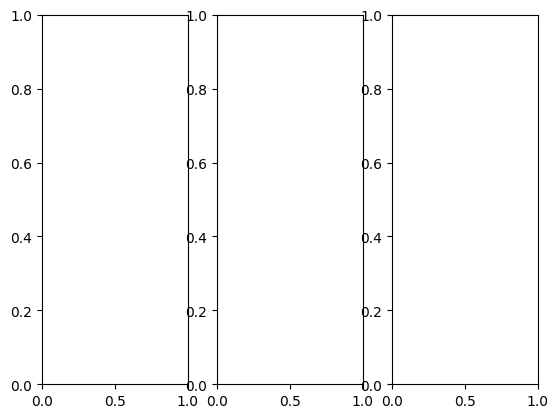

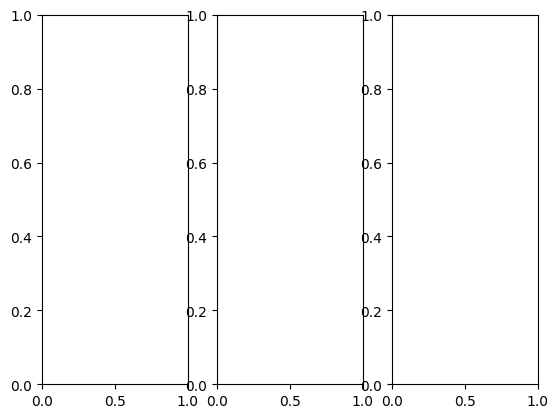

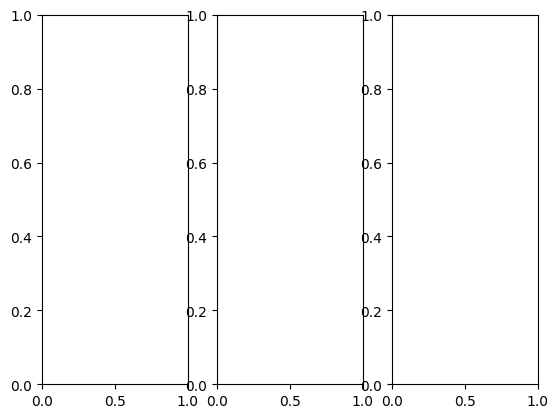

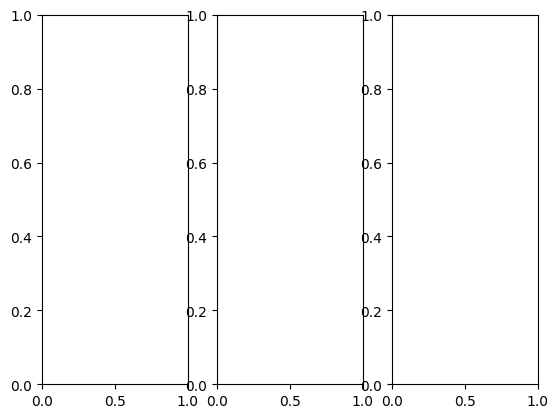

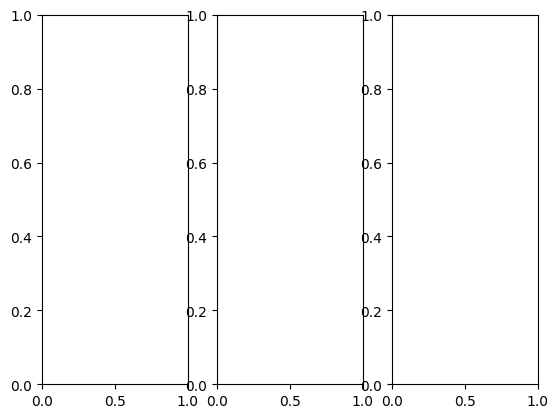

In [106]:
for t in range(10):
    #f_eq = equi_dist(rho, u)

    
    f_inm = comp_new_dist(f_inm, f_inm_eq, omega = 1)
    
    f_inm = stream(f_inm)

    rho = dens_lattice_point(f_inm)
    
    u = vel_field_lattice_point(f_inm)
    f_inm_eq = equi_dist(rho, u)
    fig, axes = plt.subplots(1,3)

#     for idx in range(2):
#         axes[idx].imshow(u[idx])
#     axes[2].imshow(rho)
#     plt.show()
    print(u[0])
    

    
    # plt.imshow(f_inm[0])
    # plt.show()

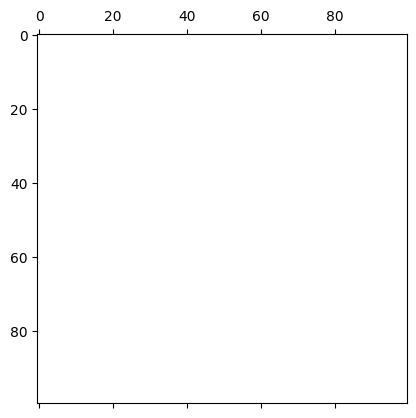

In [63]:
plt.spy(u[0])
plt.show()

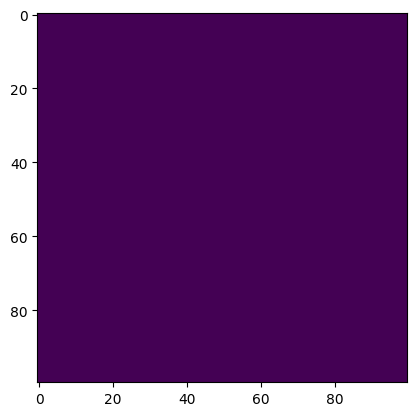

In [39]:
plt.imshow(u[1])
plt.show()

In [67]:
u.shape

(2, 100, 100)

TypeError: Invalid shape (100,) for image data

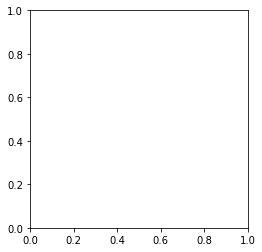

In [18]:
plt.imshow(u[0, :, 50])